In [1]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt

#TDA packages
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

<b>Read Muse data</b> (data from: https://github.com/jordan-bird/eeg-feature-generation/tree/master/dataset/original_data)

In [2]:
relaxed_data = pd.read_csv("./eeg-data/relaxed/1.txt")
relaxed_data_TP9 = relaxed_data.TP9[0:2000]
relaxed_data_TP10 = relaxed_data.TP10[0:2000]
relaxed_data_AF7 = relaxed_data.AF7[0:2000]
relaxed_data_AF8 = relaxed_data.AF8[0:2000]

concentrated_data = pd.read_csv("./eeg-data/concentrated/1.txt")
concentrated_data_TP9 = concentrated_data.TP9[0:2000]
concentrated_data_TP10 = concentrated_data.TP10[0:2000]
concentrated_data_AF7 = concentrated_data.AF7[0:2000]
concentrated_data_AF8 = concentrated_data.AF8[0:2000]

# embed relaxed EEG data into 4 dimensional electrode space
relaxed = []
start = 0
end = 49

for index in range(0, 40):
    rel_data = []
    for i in range(start,end):
        rel_data.append([relaxed_data_TP9.values[i], relaxed_data_TP10.values[i], relaxed_data_AF7.values[i], relaxed_data_AF8.values[i]])
    start = start + 50
    end = end + 50   
    relaxed.append(np.array(rel_data).copy())


# embed cencentrated EEG data into 4 dimensional electrode space
concentrated = []
start = 0
end = 49

for index in range(0, 40):
    con_data = []
    for i in range(start,end):
        con_data.append([concentrated_data_TP9.values[i], concentrated_data_TP10.values[i], concentrated_data_AF7.values[i], concentrated_data_AF8.values[i]])
    start = start + 50
    end = end + 50   
    concentrated.append(np.array(con_data).copy())

    
# combine data and put in correct format for rips algo
dataSet = []
dataSet.extend(relaxed)
dataSet.extend(concentrated)
datas = np.empty((80,50,4))
datas = np.array(dataSet, dtype="object")

# Define labels
labels = np.zeros(80)
labels[40:] = 1


<b>Visualize H0/H1 persistent homology using ripser persistence diagrams</b>

In [3]:
rips = Rips(maxdim=1, coeff=2)
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


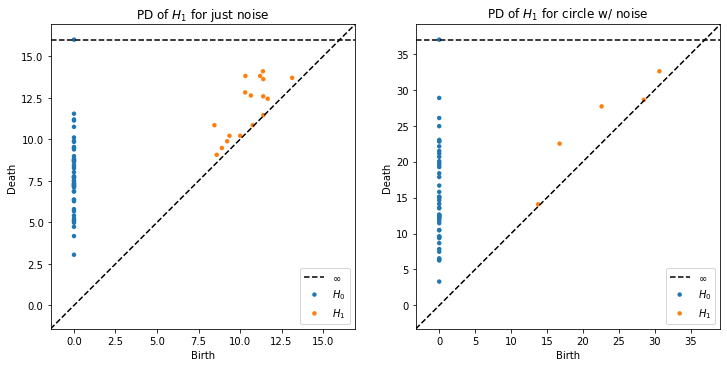

In [4]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams[0], show=False)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams[-1], show=False)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

<b>Compute persistence images of H1 persistence diagrams</b>

In [5]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

In [6]:
pimgr

PersistenceImager(birth_range=(5.021872043609619, 47.02187204360962), pers_range=(-0.30470824241638184, 14.695291757583618), pixel_size=1, weight=persistence, weight_params={'n': 1.0}, kernel=gaussian, kernel_params={'sigma': [[1.0, 0.0], [0.0, 1.0]]})

<b>Plot persistence images for a subset of diagrams</b>

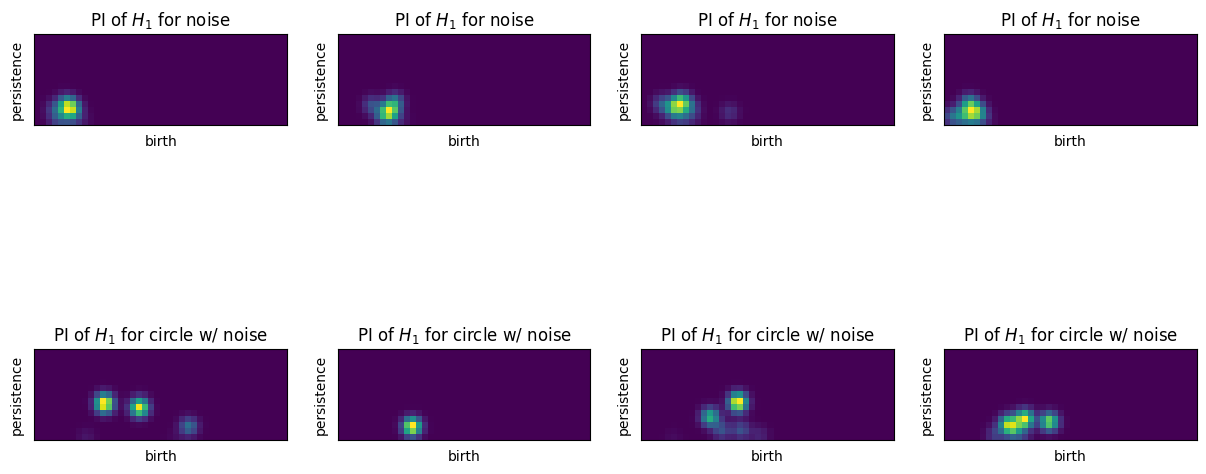

In [7]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pimgr.plot_image(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pimgr.plot_image(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

<b>Vectorize persistence images</b>

In [8]:
imgs_array = np.array([img.flatten() for img in imgs])

<b>Split data (60% train, 40% test)</b>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)


<b>Train logistic regression classifier on vectorized persistence images</b>

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
lr.score(X_test, y_test)

0.96875